In [68]:
from dotenv import load_dotenv

load_dotenv()

True

In [69]:
from typing import TypedDict


class AgentState(TypedDict):
    question: str
    answer: str
    tax_base_equation: str # 과세표준 계산 수식
    tax_deduction: str # 공제액
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산

In [70]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [71]:
# vector store 생성
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [72]:
question = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [73]:
# llm 설정
from langchain_openai import ChatOpenAI
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o")
mini_llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ("system", "사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요.  부연 설명 없이 수식만 리턴해주세요"),
    ("human", "{tax_base_equation}")
])

tax_base_retrieval_chain = (
    {"context": retriver, "question": RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

tax_base_equation_chain = (
    {"tax_base_equation": RunnablePassthrough()} 
    | tax_base_equation_prompt 
    | llm 
    | StrOutputParser()
)

tax_base_chain = { "tax_base_equation" : tax_base_retrieval_chain } | tax_base_equation_chain

def get_tax_base_equation(state: AgentState) -> str:
    question = "주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요."
    tax_base_equation = tax_base_chain.invoke(question)

    print(f"tax_base_equation: {tax_base_equation}")
    return {"tax_base_equation": tax_base_equation}



In [75]:
# get_tax_base_equation({})

# {'tax_base_equation': '과세표준 = (Σ(주택 공시가격) - 공제금액) × 공정시장가액비율'}

In [ ]:
tax_deduction_retrieval_chain = (
    {"context": retriver, "question": RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState) -> str:
    question = "주택에 대한 종합부동산세 계산시 공제금액을 알려주세요."
    tax_deduction = tax_deduction_retrieval_chain.invoke(question)

    print(f"tax_deduction: {tax_deduction}")
    return {"tax_deduction": tax_deduction}

In [77]:
# get_tax_deduction({})

In [78]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavliy_search_tool = TavilySearchResults(
    max_results=8,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ("system", "아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext: {context}"),
    ("human", "{question}")
])

tax_market_ratio_chain = tax_market_ratio_prompt | llm | StrOutputParser()

def get_tax_market_ratio(state: AgentState) :
    question = f'오늘 날짜 ({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇%인가요?'
    search_tool = tavliy_search_tool.as_tool()
    context = search_tool.invoke({"query": question})
    market_ratio = tax_market_ratio_chain.invoke({"context": context, "question": question})

    print(f"market_ratio: {market_ratio}")
    return {"market_ratio": market_ratio}


In [79]:
# get_tax_market_ratio({})

In [80]:
tax_base_calculation_prompt = ChatPromptTemplate.from_messages([
    ("system", """주어진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 수식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}"""),
    ("human", "사용자의 주택 공시가격 정보: {question}")
])

def calculate_tax(state: AgentState) :
    tax_base_equation = state["tax_base_equation"]
    tax_deduction = state["tax_deduction"]
    market_ratio = state["market_ratio"]
    question = state["question"]

    tax_base_calculation_chain = (
        tax_base_calculation_prompt 
        | llm 
        | StrOutputParser()
    )
    tax_base = tax_base_calculation_chain.invoke({
        "tax_base_equation": tax_base_equation,
        "tax_deduction": tax_deduction,
        "market_ratio": market_ratio,
        "question": question
    })

    print(f"tax_base: {tax_base}")
    return {"tax_base": tax_base}
    

In [81]:
initial_state = {
    'tax_base_equation': '과세표준 = (Σ(주택 공시가격) - 공제금액) × 공정시장가액비율',
    'market_ratio': '2025년 주택 공시가격 공정시장가액비율은 1주택자의 경우 공시가격 구간에 따라 43%에서 45%까지 적용되고, 다주택자나 법인의 경우에는 60%가 적용됩니다.',
    'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자는 12억 원, 그 외의 경우는 9억 원입니다.',
    'question': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'
}

In [82]:
# calculate_tax(initial_state)

In [83]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ("system", "당신은 종합 부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요 \n\n 종합부동산세 세율: {context}"),
    ("human", """과세표준과 사용자가 소지한 주택수가 아래와 같을 때 종합부동산세를 계산해주세요
    과세표준: {tax_base}
    사용자의 주택 수: {question}""")
])

tax_rate_calculation_chain = tax_rate_calculation_prompt | llm | StrOutputParser()

def calculate_tax_rate(state: AgentState) :
    question = state["question"]
    tax_base = state["tax_base"]
    context = retriver.invoke(question)
    tax_rate = tax_rate_calculation_chain.invoke({
        "context": context,
        "question": question,
        "tax_base": tax_base
    })

    print(f"answer: {tax_rate}")
    return {"answer": tax_rate}


In [ ]:
# calculate_tax_rate({
#     'tax_base': '주어진 정보를 바탕으로 사용자의 경우 다주택자이므로 해당 조건에 맞춰 과세표준을 계산해보겠습니다.\n\n1. 주택 공시가격의 합계:\n   - 5억 원 + 10억 원 + 20억 원 = 35억 원\n\n2. 공제금액:\n   - 다주택자의 경우 공제금액은 9억 원입니다.\n\n3. 공정시장가액비율:\n   - 다주택자의 경우 60%가 적용됩니다.\n\n과세표준 계산:\n\\( \\text{과세표준} = (\\Sigma \\text{주택 공시가격} - \\text{공제금액}) \\times \\text{공정시장가액비율} \\)\n\n\\( \\text{과세표준} = (35억 원 - 9억 원) \\times 0.60 \\)\n\n\\( \\text{과세표준} = 26억 원 \\times 0.60 \\)\n\n\\( \\text{과세표준} = 15.6억 원 \\)\n\n따라서, 과세표준은 15.6억 원입니다. 이 과세표준을 바탕으로 종합부동산세를 계산하게 됩니다. 다만, 정확한 세금 금액은 세율 및 기타 세부적인 계산식에 따라 달라질 수 있습니다.',
#     'question': question
# })

answer: 주어진 정보를 바탕으로 사용자는 3주택을 소유하고 있으며, 과세표준은 15.6억 원으로 계산되었습니다. 이제, 3주택 이상 소유자의 종합부동산세 세율을 적용하여 세금을 계산해보겠습니다.

1. 과세표준: 15.6억 원

2. 3주택 이상 소유자의 세율에 따라 과세표준에 해당하는 구간 확인:
   - 12억 원 초과 25억 원 이하 구간에 해당됩니다.

3. 해당 구간의 세율:
   - 기본 세액: 960만 원
   - 초과분에 대한 세율: 12억 원을 초과하는 금액의 1천분의 20

4. 세금 계산:
   - 초과분: 15.6억 원 - 12억 원 = 3.6억 원
   - 초과분에 대한 세액: 3.6억 원 × 0.002 = 720만 원
   - 최종 세액: 960만 원 + 720만 원 = 1,680만 원

따라서, 사용자가 내야 할 종합부동산세는 1,680만 원입니다.


{'answer': '주어진 정보를 바탕으로 사용자는 3주택을 소유하고 있으며, 과세표준은 15.6억 원으로 계산되었습니다. 이제, 3주택 이상 소유자의 종합부동산세 세율을 적용하여 세금을 계산해보겠습니다.\n\n1. 과세표준: 15.6억 원\n\n2. 3주택 이상 소유자의 세율에 따라 과세표준에 해당하는 구간 확인:\n   - 12억 원 초과 25억 원 이하 구간에 해당됩니다.\n\n3. 해당 구간의 세율:\n   - 기본 세액: 960만 원\n   - 초과분에 대한 세율: 12억 원을 초과하는 금액의 1천분의 20\n\n4. 세금 계산:\n   - 초과분: 15.6억 원 - 12억 원 = 3.6억 원\n   - 초과분에 대한 세액: 3.6억 원 × 0.002 = 720만 원\n   - 최종 세액: 960만 원 + 720만 원 = 1,680만 원\n\n따라서, 사용자가 내야 할 종합부동산세는 1,680만 원입니다.'}

In [85]:
graph_builder.add_node("get_tax_base_equation", get_tax_base_equation)
graph_builder.add_node("get_tax_deduction", get_tax_deduction)
graph_builder.add_node("get_tax_market_ratio", get_tax_market_ratio)
graph_builder.add_node("calculate_tax", calculate_tax)
graph_builder.add_node("calculate_tax_rate", calculate_tax_rate)

In [86]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "get_tax_base_equation")
graph_builder.add_edge(START, "get_tax_deduction")
graph_builder.add_edge(START, "get_tax_market_ratio")


graph_builder.add_edge("get_tax_base_equation", "calculate_tax")
graph_builder.add_edge("get_tax_deduction", "calculate_tax")
graph_builder.add_edge("get_tax_market_ratio", "calculate_tax")

graph_builder.add_edge("calculate_tax", "calculate_tax_rate")
graph_builder.add_edge("calculate_tax_rate", END)

In [87]:
graph = graph_builder.compile()

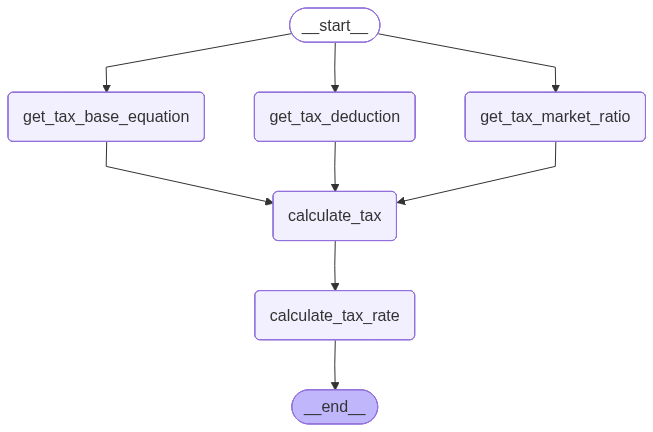

In [88]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [89]:
initial_state = {
    'question': question
}

In [90]:
graph.invoke(initial_state)

market_ratio: 2025년의 주택 공시가격 공정시장가액비율은 1주택자의 경우, 3억 이하 43%, 3억 초과 6억 이하는 44%, 6억 초과는 45%로 적용됩니다. 다주택자나 법인의 경우 기본 비율 60%가 적용됩니다.
tax_base: 사용자의 주택 공시가격 합산금액은 5억 + 10억 + 20억 = 35억 원입니다.

이 경우, 사용자는 다주택자로 간주되며, 공제금액으로 9억 원이 적용됩니다.

따라서 과세표준은 다음과 같이 계산됩니다:

과세표준 = (공시가격 합산금액 - 공제금액) × 공정시장가액비율
          = (35억 - 9억) × 60%
          = 26억 × 0.60
          = 15.6억 원

과세표준은 15.6억 원입니다. 이 금액을 기준으로 종합부동산세를 계산하게 됩니다. 종합부동산세율을 알면, 세금 금액을 구할 수 있습니다. 그러나 주어진 정보만으로는 세율은 알 수 없습니다. 기본적인 과세 표준만 계산된 상태입니다.
answer: 사용자는 3주택 이상을 소유한 경우에 해당합니다. 주어진 정보에 따라 과세 표준은 15.6억 원입니다. 이에 따라 세율을 적용하여 종합부동산세를 계산할 수 있습니다.

3주택 이상 소유자의 경우 과세표준에 따른 세율은 다음과 같습니다:

- 12억 원 초과 25억 원 이하: 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)

주어진 과세 표준은 15.6억 원이므로, 12억 원을 초과하는 금액은 3.6억 원입니다.

따라서:
- 초과 금액에 대한 세액: 3.6억 원 × 0.002 = 720만 원
- 총 세금: 960만 원 + 720만 원 = 1,680만 원

따라서 사용자는 종합부동산세로 1,680만 원을 납부하게 됩니다.


{'question': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '사용자는 3주택 이상을 소유한 경우에 해당합니다. 주어진 정보에 따라 과세 표준은 15.6억 원입니다. 이에 따라 세율을 적용하여 종합부동산세를 계산할 수 있습니다.\n\n3주택 이상 소유자의 경우 과세표준에 따른 세율은 다음과 같습니다:\n\n- 12억 원 초과 25억 원 이하: 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)\n\n주어진 과세 표준은 15.6억 원이므로, 12억 원을 초과하는 금액은 3.6억 원입니다.\n\n따라서:\n- 초과 금액에 대한 세액: 3.6억 원 × 0.002 = 720만 원\n- 총 세금: 960만 원 + 720만 원 = 1,680만 원\n\n따라서 사용자는 종합부동산세로 1,680만 원을 납부하게 됩니다.',
 'tax_base_equation': '과세표준 = (공시가격 합산금액 - 공제금액) × 공정시장가액비율',
 'tax_deduction': '주택에 대한 종합부동산세를 계산할 때, 1세대 1주택자는 공제금액으로 12억 원까지 적용됩니다. 법인이나 법인으로 보는 단체는 공제금액으로 6억 원이 적용됩니다. 그 외의 경우에는 공제금액으로 9억 원이 적용됩니다.',
 'market_ratio': '2025년의 주택 공시가격 공정시장가액비율은 1주택자의 경우, 3억 이하 43%, 3억 초과 6억 이하는 44%, 6억 초과는 45%로 적용됩니다. 다주택자나 법인의 경우 기본 비율 60%가 적용됩니다.',
 'tax_base': '사용자의 주택 공시가격 합산금액은 5억 + 10억 + 20억 = 35억 원입니다.\n\n이 경우, 사용자는 다주택자로 간주되며, 공제금액으로 9억 원이 적용됩니다.\n\n따라서 과세표준은 다음과 같이 계산됩니다:\n\n과세표준 = (공시가격 합산금액 - 공제금액) × 공정시장가액비율\n          = (35억 - 9억) × 60%\n